## 回归模型扩展
目标变量通常有很多影响因素，通过各类影响因素构建对目标变量的回归模型，能够实现对目标的预测。但根据稀疏性的假设，即使影响一个变量的因素有很多，其关键因素永远只是少数。在这种情况下，还用传统的线性回归方法来处理的话，效果可能并不理想。下面介绍两种线性回归模型的拓展模型，分别是`LASSO回归`和`Ridge回归`。

### 1 lasso回归原理推导
为了从众多因素中找出关键因素（例如寻找影响房价的关键因素），我们先来看`LASSO`(`the least absolute shrinkage and selection operator`)回归模型，可以译为`最小绝对收缩和选择算子`。由chapter2的线性回归可知，线性回归的最优参数估计表达式为：
$$ \hat{w}^{*} =\left ( X^{T}X \right )^{-1}X^{T}y  $$
假设训练样本数为$m$，样本特征数为$n$，按照惯例，就有$m>n$，即样本量大于特征数。当$m>n$时，若$rank(X)=n$，即$X$为满秩矩阵，则$X^TX$是可逆矩阵，上式是可以直接求解的。但如果$m<n$，即特征数大于样本量时，$rank(X)<n$，矩阵X不满秩，$X^TX$不可逆，这时上式中的参数$\hat{w}^{*}$是不可估计的。

对于这个问题，`LASSO回归`给出的做法是在线性回归的损失函数后面加上一个`1-范数项`，也叫做`正则化项`：
$$L\left ( w \right )=\left ( y-wX \right ) ^{2}+\lambda \left \| w \right \|_{1} $$
其中$\left \| w \right \|_{1} $即为矩阵的1-范数，$\lambda$为1-范数项的系数。

在数学分析中，`范数`(`norm`)可视为一种长度或距离概念的函数。针对向量或者矩阵而言，常用的范数包括`0-范数`、`1-范数`、`2-范数`和`p-范数`等。
$$\left \| x \right \| _{p} =\sqrt[p]{\sum_{i}^{} \left | x_{i}  \right | ^{p} } $$
矩阵的0-范数为矩阵中非零元素的个数，矩阵的`1-范数`可定义为矩阵中所有元素的绝对值之和，而矩阵的`2-范数`是指矩阵中各元素的平方和再求均方根的结果。

从防止模型过拟合的角度而言，正则化项相当于对目标参数施加了一个惩罚项，使得模型不能过于复杂。在优化过程中，正则化项的存在能够使那些不重要的特征系数逐渐为零，从而保留关键特征，使得模型简化。LASSO回归可以看作是**强制系数绝对值之和小于某个固定值**。原式可以化解为：
$$argmin\left ( y-wX \right ) ^{2}$$
$$s.t.\sum \left | w_{ij}  \right |< s $$

第一个式子为线性回归目标函数，第二个式子为其约束条件，即权重系数矩阵所有元素绝对值之和小于一个指定常数$s$，$s$取值越小，特征参数中被压缩到零的特征就会越多。

最后一个关键问题是如何针对LASSO回归的目标函数进行参数优化。L1正则化项的存在使得式子为连续不可导的函数，直接使用梯度下降法无法进行寻优，一种替代寻优方法为`坐标下降法`(`cordinate descent method`)。坐标下降法是一种迭代算法，相较于梯度下降法通过损失函数的负梯度来确定下降方向，坐标下降法是在当前坐标轴上搜索损失函数的最小值，无需计算函数梯度。

### 2 LASSO回归的代码实现
由于我们在之前以及编写过线性回归的代码（使用梯度下降来优化），我们设计定义一个符号函数作为L1损失的梯度计算辅助函数，从而达到使用梯度下降寻优的目的（这样处理结果其实更像岭回归）。

In [53]:
import numpy as np

# 定义符号函数
def sign(x):
    
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0

# 利用numpy对符号函数进行向量化
vec_sign = np.vectorize(sign)

In [54]:
# 定义LASSO回归损失函数
def l1_loss(X, y, w, b, alpha): # alpha：正则化系数

    num_train = X.shape[0]
    y_hat = np.dot(X, w) + b # 回归模型预测输出
    loss = np.sum((y_hat - y) ** 2) / num_train + np.sum(alpha * abs(w)) # L1损失函数
    dw = np.dot(X.T, (y_hat-y)) / num_train + alpha * vec_sign(w) # *基于向量化符号函数的参数梯度计算
    db = np.sum((y_hat-y)) / num_train

    return y_hat, loss, dw, db # y_hat：线性模型预测输出

In [55]:
# 初始化模型参数
def initialize_params(dims):
    w = np.zeros((dims, 1))
    b = 0
    return w, b

alpha = 0.1
# lasso回归模型的训练过程
def lasso_train(X, y, learning_rate=0.01, epochs=1000):
    loss_his = []
    num_feature = X.shape[1]
    w, b = initialize_params(num_feature)
    for i in range(1, epochs):
        y_hat, loss, dw, db = l1_loss(X, y, w, b, alpha)
        w += -learning_rate * dw
        b += -learning_rate * db
        loss_his.append(loss)
        if i % 50 == 0:
            print(f'epoch {i} loss {loss}')
        params = {'w': w, 'b': b}
        grads = {'dw': dw, 'db': db}
    return loss_his, params, grads

In [56]:
data = np.genfromtxt('example.dat', delimiter=',')
x ,y = data[:, 0:100], data[:, 100].reshape(-1, 1) # 取特征和标签
X = np.column_stack((np.ones((x.shape[0], 1)), x)) # 使用np.column_stack()函数将其与特征集x合并，形成一个增强矩阵X
X_train, y_train, X_test, y_test = X[:70], y[:70], X[70:], y[70:] # 划分数据集

In [57]:
learning_rate, epochs = 0.01, 3000
loss_list, params, grads = lasso_train(X_train, y_train, learning_rate, epochs)
print('w:', np.squeeze(np.around(params['w'], 3), axis=1))
print('b:', params['b'])

epoch 50 loss 3.197738143405899
epoch 100 loss 2.2979337861207645
epoch 150 loss 1.9900751943036639
epoch 200 loss 1.8320266591199932
epoch 250 loss 1.7344667338968494
epoch 300 loss 1.6738667129364397
epoch 350 loss 1.6348491241969825
epoch 400 loss 1.608013365930367
epoch 450 loss 1.589218412681317
epoch 500 loss 1.5748820502732412
epoch 550 loss 1.5646023487751468
epoch 600 loss 1.5552810803037382
epoch 650 loss 1.5478833692013774
epoch 700 loss 1.5418790733417627
epoch 750 loss 1.5362930403512336
epoch 800 loss 1.5317412339045542
epoch 850 loss 1.5280959941150483
epoch 900 loss 1.5243161101422968
epoch 950 loss 1.5218177347840784
epoch 1000 loss 1.5185780361271004
epoch 1050 loss 1.5164119056223444
epoch 1100 loss 1.5144597376883366
epoch 1150 loss 1.5132435251612562
epoch 1200 loss 1.5119755216055641
epoch 1250 loss 1.5115335544116735
epoch 1300 loss 1.5109892208015951
epoch 1350 loss 1.5105885595863704
epoch 1400 loss 1.509908014541425
epoch 1450 loss 1.5096914825452354
epoch 150

In [58]:
# 定义预测函数
def predict(X, params):
    w = params['w']
    b = params['b']
    
    y_pred = np.dot(X, w) + b
    return y_pred

y_pred = predict(X_test, params)
y_pred[:5], y_test[:5]

(array([[-0.46873492],
        [-2.8694067 ],
        [ 0.44566828],
        [-0.55241025],
        [-3.15848274]]),
 array([[ 0.24671],
        [-4.25711],
        [ 2.38642],
        [-1.87815],
        [-3.41362]]))

In [59]:
from sklearn.metrics import r2_score
r2_score(y_pred, y_test)

0.5704547131357189

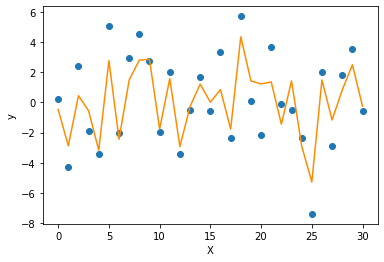

In [60]:
# 简单绘图
import matplotlib.pyplot as plt
f = X_test.dot(params['w']) + params['b']

plt.scatter(range(X_test.shape[0]), y_test)
plt.plot(f, color = 'darkorange')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

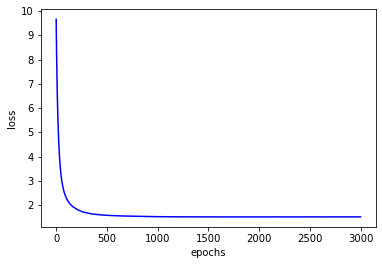

In [61]:
# 训练过程中的损失下降
plt.plot(loss_list, color = 'blue')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 3 基于sklearn实现LASSO回归
跟线性回归和对数几率回归等线性模型一样，LASSO回归模型接口也位于`linear_model`模块下。

In [62]:
from sklearn import linear_model
sk_lasso = linear_model.Lasso(alpha=0.1)
sk_lasso.fit(X_train, y_train)
# 打印模型相关系数
print("sklearn Lasso intercept :", sk_lasso.intercept_)
print("sklearn Lasso coefficients :\n", sk_lasso.coef_)
print("sklearn Lasso number of iterations :", sk_lasso.n_iter_)

sklearn Lasso intercept : [-0.23824815]
sklearn Lasso coefficients :
 [ 0.         -0.          0.59804516  0.64230683  0.          1.0070841
 -0.          0.81815409 -0.22756851  0.          0.          0.793601
  0.          0.74108335 -0.         -0.1250168  -0.          0.79407074
  0.          0.81867433  0.          0.         -0.          0.56664364
 -0.         -0.         -0.         -0.         -0.          0.49526526
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.
  0.         -0.         -0.0078254   0.          0.         -0.
 -0.          0.01986066  0.         -0.          0.         -0.
  0.         -0.06797763  0.24581414  0.         -0.04180909 -0.
  0.10542471  0.03156005  0.          0.          0.         -0.
 -0.          0.         -0.          0.12548825  0.2340209  -0.
  0.          0.16875552  0.          0.01596168  0.         -0.
  0.          0.         -0.          0.20050804

### 4 Ridge回归原理推导

类似于LASSO回归模型，Ridge回归(`岭回归`)是一种使用2-范数作为惩罚项改造线性回归损失函数的模型：
$$L\left ( w \right )=\left ( y-wX \right ) ^{2}+\lambda \left \| w \right \|_{2} $$
采用2-范数进行正则化的原理是最小化参数矩阵的每个元素，使其无限接近0又不像L1那样等于0，从而防止模型过于复杂，减少过拟合：
$$argmin\left ( y-wX \right ) ^{2}$$
$$s.t.\sum w_{ij}^{2}< s $$
所以在使用岭回归时，线性回归的最优参数估计表达式可以改写为：
$$\hat{w}^{*} =\left ( X^{T}X +  \lambda I\right )^{-1}X^{T}y$$
通过给$X^TX$加上一个单位矩阵使其变成非奇异矩阵可以进行求逆运算，从而求解岭回归。

岭回归的参数求解相比lasso回归要更容易一点，一方面我们可以直接基于上述矩阵运算进行求解，另一方面，也可以按照梯度下降进行迭代计算。

### 5 Ridge回归的代码实现
Ridge回归的参数大多比较接近0，但都不等于0，这也正是Ridge回归的一个特征。

In [63]:
# 定义ridge损失函数
def l2_loss(X, y, w, b, alpha):
    num_train = X.shape[0]
    y_hat = np.dot(X, w) + b
    loss = np.sum((y_hat-y)**2)/num_train + alpha*(np.sum(np.square(w)))
    dw = np.dot(X.T, (y_hat-y)) /num_train + 2*alpha*w
    db = np.sum((y_hat-y)) /num_train
    return y_hat, loss, dw, db

In [64]:
# 定义训练过程
def ridge_train(X, y, learning_rate=0.01, epochs=300):
    loss_list = []
    w, b = initialize_params(X.shape[1])
    for i in range(1, epochs):
        y_hat, loss, dw, db = l2_loss(X, y, w, b, 0.1)
        w += -learning_rate * dw
        b += -learning_rate * db
        loss_list.append(loss)
        
        if i % 100 == 0:
            print('epoch %d loss %f' % (i, loss))
        params = {
            'w': w,
            'b': b
        }
        grads = {
            'dw': dw,
            'db': db
        }
    return loss, loss_list, params, grads

In [74]:
loss, loss_list, params, grads = ridge_train(X_train, y_train, 0.01, 1000) # 执行训练示例
print('w:', np.squeeze(params['w'], axis=1)) # 获取训练参数
print('x:', params['b'])

epoch 100 loss 1.272892
epoch 200 loss 0.918566
epoch 300 loss 0.824857
epoch 400 loss 0.786619
epoch 500 loss 0.767618
epoch 600 loss 0.757040
epoch 700 loss 0.750696
epoch 800 loss 0.746687
epoch 900 loss 0.744053
w: [-0.04196546 -0.10129988  0.39150459  0.27116379  0.14453605  0.64205522
 -0.11777636  0.63100371 -0.24612371 -0.01809963 -0.0098817   0.59860774
  0.05109339  0.57323775  0.0717013  -0.2494207   0.05841939  0.34882372
 -0.05196151  0.59741259  0.07360193 -0.00804983 -0.08417487  0.38967928
 -0.02238394 -0.05105738 -0.04475576 -0.04810095 -0.05424062  0.36298941
  0.09421072  0.12947524  0.12975187  0.13770473 -0.11610581 -0.03832583
  0.07592514 -0.05664576 -0.01481198 -0.13093971 -0.03888878  0.04806379
  0.07572836  0.02141963 -0.0614007   0.06729191  0.04008781 -0.10963405
  0.01420552  0.16873802  0.0224207  -0.15348103  0.14905584  0.01561819
 -0.02441497 -0.03295334  0.25312019 -0.04258556 -0.29287108 -0.29727421
  0.24557737  0.09651535  0.08340742  0.10361739  0

In [66]:
# 定义预测函数
def predict(X, params):
    w = params['w']
    b = params['b']
    
    y_pred = np.dot(X, w) + b
    return y_pred

y_pred = predict(X_test, params)
y_pred[:5], y_test[:5]

(array([[-0.07363409],
        [-2.23904964],
        [ 1.35392332],
        [-2.21912506],
        [-2.56515114]]),
 array([[ 0.24671],
        [-4.25711],
        [ 2.38642],
        [-1.87815],
        [-3.41362]]))

In [67]:
from sklearn.metrics import r2_score
r2_score(y_pred, y_test)

-0.6338800998887395

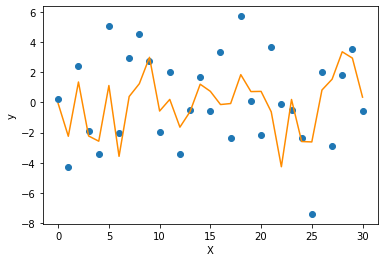

In [68]:
# 简单绘图
import matplotlib.pyplot as plt
f = X_test.dot(params['w']) + params['b']

plt.scatter(range(X_test.shape[0]), y_test)
plt.plot(f, color = 'darkorange')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

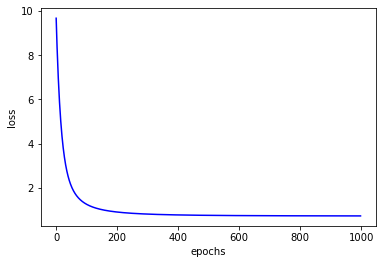

In [69]:
# 训练过程中的损失下降
plt.plot(loss_list, color = 'blue')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 5 基于sklearn实现Ridge回归

In [78]:
from sklearn import linear_model
sk_ridge = linear_model.Ridge(alpha=0.1)
sk_ridge.fit(X_train, y_train)
# 打印模型相关系数
print("sklearn Ridge intercept :", sk_ridge.intercept_)
print("sklearn Ridge coefficients :\n", sk_ridge.coef_)

sklearn Ridge intercept : [-0.44716745]
sklearn Ridge coefficients :
 [[ 0.00000000e+00 -2.21924064e-01  5.69466502e-01  3.36064437e-01
   5.56461978e-02  8.94144345e-01 -1.35299364e-01  9.39282164e-01
  -4.42801303e-01  1.93811401e-01 -2.86524799e-02  6.18802397e-01
   4.57492790e-02  9.85553487e-01  1.26863833e-01 -4.04671026e-01
   1.84346967e-01  4.11803018e-01 -1.51682432e-02  9.41228573e-01
   2.58441884e-02  9.27160807e-04 -2.01072144e-01  4.60038386e-01
  -9.07493310e-02 -1.60743100e-01  7.32780370e-02  3.82390023e-03
  -5.60760916e-02  3.64496319e-01  8.07636580e-02  1.40905536e-01
   1.36431477e-01  2.08250238e-01 -1.81259555e-01 -4.24181872e-02
   2.33675103e-01 -3.72421594e-02 -1.36930634e-01 -4.03230666e-01
   1.25982752e-01 -5.13856468e-02  1.99502503e-02  1.11568597e-01
  -2.41177874e-02 -1.02227356e-02  1.45922593e-02 -1.63169648e-01
  -2.55961129e-01 -7.43539388e-02  1.61760355e-01 -2.47603096e-01
   1.77369919e-01  1.80063093e-02 -1.61125062e-01 -9.38294794e-02
   3.2

从数学角度来看，LASSO回归和Ridge回归都是在$X^TX$为不可逆矩阵的情况下，求解回归参属的一种“妥协”性的方法，通过给常规的平方损失函数添加L1正则化项和L2正则化项，使得回归问题有可行解，虽然这是一种有偏估计。

从业务可解释性角度来看，影响一个变量的因素有很多，但关键因素永远只会是少数。当影响一个变量的因素有很多时（特征数大于样本量），用传统线性回归的方法来处理可能效果不太理想，这时候也可以使用到LASSO回归和Ridge回归。

L1正则化对于参数进行了稀疏化处理，即某些参数可以被设置为0，因此 Lasso 回归的参数可以为0。这意味着 Lasso 回归可以用于特征选择，因为它可以将不相关或冗余的特征的系数设为0，从而剔除这些特征。

L2正则化对于参数进行了平滑化处理，但并不会将任何参数精确地设置为0，而是让参数尽量接近于0。这是因为在岭回归中，正则化项的导数对于参数的影响是线性的，没有一个阈值能够精确地将参数设为0。

因此，Lasso 回归可以在适当的情况下选择特征并将一些参数设置为0，而岭回归则更倾向于将参数约束在接近于零的范围内，但不完全等于0。这使得岭回归在对特征进行选择时相对较保守，而 Lasso 回归在特征选择和稀疏性建模方面更为强大。